<a href="https://colab.research.google.com/github/sawarn69/GANs/blob/master/GANs_using_MNIST_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Go to this link for line by line code explanation

#### https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3


### More links to understand GANs
https://medium.com/@jonathan_hui/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09

https://junyanz.github.io/CycleGAN/
https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from tensorflow.python.keras.layers import Dense, Dropout, Input
from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras.datasets import mnist
from tqdm import tqdm
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

##  https://stackoverflow.com/questions/47262955/how-to-import-keras-from-tf-keras-in-tensorflow

Using TensorFlow backend.


In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)


In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [0]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
        

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 3/128 [00:00<00:04, 27.04it/s]

Epoch 2


  2%|▏         | 3/128 [00:00<00:04, 26.69it/s]

Epoch 3


  2%|▏         | 3/128 [00:00<00:04, 29.16it/s]

Epoch 4


  2%|▏         | 3/128 [00:00<00:04, 26.98it/s]

Epoch 5


  3%|▎         | 4/128 [00:00<00:03, 32.35it/s]

Epoch 6


  3%|▎         | 4/128 [00:00<00:04, 28.72it/s]

Epoch 7


  3%|▎         | 4/128 [00:00<00:03, 31.86it/s]

Epoch 8


  2%|▏         | 3/128 [00:00<00:04, 25.42it/s]

Epoch 9


  2%|▏         | 3/128 [00:00<00:04, 29.08it/s]

Epoch 10


  2%|▏         | 3/128 [00:00<00:04, 29.18it/s]

Epoch 11


  3%|▎         | 4/128 [00:00<00:03, 32.02it/s]

Epoch 12


  3%|▎         | 4/128 [00:00<00:04, 28.86it/s]

Epoch 13


  3%|▎         | 4/128 [00:00<00:03, 31.76it/s]

Epoch 14


  2%|▏         | 3/128 [00:00<00:04, 28.26it/s]

Epoch 15


  3%|▎         | 4/128 [00:00<00:03, 32.09it/s]

Epoch 16


  2%|▏         | 3/128 [00:00<00:04, 27.53it/s]

Epoch 17


  3%|▎         | 4/128 [00:00<00:03, 32.03it/s]

Epoch 18


  2%|▏         | 3/128 [00:00<00:04, 29.01it/s]

Epoch 19


  2%|▏         | 3/128 [00:00<00:04, 29.68it/s]

Epoch 20


  2%|▏         | 3/128 [00:00<00:04, 28.83it/s]

Epoch 21


  2%|▏         | 3/128 [00:00<00:04, 26.14it/s]

Epoch 22


  2%|▏         | 3/128 [00:00<00:04, 27.70it/s]

Epoch 23


  3%|▎         | 4/128 [00:00<00:03, 32.06it/s]

Epoch 24


  2%|▏         | 3/128 [00:00<00:04, 26.65it/s]

Epoch 25


  3%|▎         | 4/128 [00:00<00:04, 30.79it/s]

Epoch 26


  2%|▏         | 3/128 [00:00<00:04, 28.05it/s]

Epoch 27


  2%|▏         | 3/128 [00:00<00:04, 29.65it/s]

Epoch 28


  3%|▎         | 4/128 [00:00<00:04, 30.58it/s]

Epoch 29


  3%|▎         | 4/128 [00:00<00:03, 31.30it/s]

Epoch 30


  3%|▎         | 4/128 [00:00<00:03, 32.27it/s]

Epoch 31


  3%|▎         | 4/128 [00:00<00:04, 30.19it/s]

Epoch 32


  2%|▏         | 3/128 [00:00<00:04, 25.15it/s]

Epoch 33


  3%|▎         | 4/128 [00:00<00:03, 31.10it/s]

Epoch 34


  2%|▏         | 3/128 [00:00<00:04, 27.11it/s]

Epoch 35


  3%|▎         | 4/128 [00:00<00:03, 31.09it/s]

Epoch 36


  3%|▎         | 4/128 [00:00<00:04, 30.95it/s]

Epoch 37


  2%|▏         | 3/128 [00:00<00:04, 29.44it/s]

Epoch 38


  2%|▏         | 3/128 [00:00<00:04, 27.67it/s]

Epoch 39


  3%|▎         | 4/128 [00:00<00:03, 32.10it/s]

Epoch 40


  3%|▎         | 4/128 [00:00<00:04, 30.72it/s]

Epoch 41


  2%|▏         | 3/128 [00:00<00:04, 29.37it/s]

Epoch 42


  3%|▎         | 4/128 [00:00<00:03, 31.22it/s]

Epoch 43


  3%|▎         | 4/128 [00:00<00:03, 31.73it/s]

Epoch 44


  3%|▎         | 4/128 [00:00<00:03, 33.00it/s]

Epoch 45


  2%|▏         | 3/128 [00:00<00:04, 28.50it/s]

Epoch 46


  3%|▎         | 4/128 [00:00<00:04, 29.70it/s]

Epoch 47


  3%|▎         | 4/128 [00:00<00:03, 31.76it/s]

Epoch 48


  3%|▎         | 4/128 [00:00<00:03, 31.57it/s]

Epoch 49


  3%|▎         | 4/128 [00:00<00:03, 31.65it/s]

Epoch 50


  3%|▎         | 4/128 [00:00<00:04, 30.78it/s]

Epoch 51


  2%|▏         | 3/128 [00:00<00:04, 27.10it/s]

Epoch 52


  3%|▎         | 4/128 [00:00<00:03, 32.52it/s]

Epoch 53


  3%|▎         | 4/128 [00:00<00:03, 31.71it/s]

Epoch 54


  3%|▎         | 4/128 [00:00<00:03, 31.02it/s]

Epoch 55


  3%|▎         | 4/128 [00:00<00:03, 31.52it/s]

Epoch 56


  3%|▎         | 4/128 [00:00<00:03, 31.13it/s]

Epoch 57


  3%|▎         | 4/128 [00:00<00:03, 31.89it/s]

Epoch 58


  2%|▏         | 3/128 [00:00<00:04, 27.70it/s]

Epoch 59


  3%|▎         | 4/128 [00:00<00:03, 32.79it/s]

Epoch 60


  2%|▏         | 3/128 [00:00<00:04, 28.73it/s]

Epoch 61


  3%|▎         | 4/128 [00:00<00:03, 31.59it/s]

Epoch 62


  2%|▏         | 3/128 [00:00<00:04, 28.80it/s]

Epoch 63


  3%|▎         | 4/128 [00:00<00:03, 31.58it/s]

Epoch 64


  3%|▎         | 4/128 [00:00<00:04, 30.68it/s]

Epoch 65


  3%|▎         | 4/128 [00:00<00:03, 32.13it/s]

Epoch 66


  3%|▎         | 4/128 [00:00<00:03, 31.09it/s]

Epoch 67


  3%|▎         | 4/128 [00:00<00:03, 32.47it/s]

Epoch 68


  2%|▏         | 3/128 [00:00<00:04, 27.36it/s]

Epoch 69


  2%|▏         | 3/128 [00:00<00:04, 28.36it/s]

Epoch 70


  3%|▎         | 4/128 [00:00<00:04, 30.84it/s]

Epoch 71


  3%|▎         | 4/128 [00:00<00:04, 28.74it/s]

Epoch 72


  3%|▎         | 4/128 [00:00<00:04, 30.88it/s]

Epoch 73


  2%|▏         | 3/128 [00:00<00:04, 29.65it/s]

Epoch 74


  2%|▏         | 3/128 [00:00<00:04, 28.21it/s]

Epoch 75


  2%|▏         | 3/128 [00:00<00:04, 29.04it/s]

Epoch 76


  3%|▎         | 4/128 [00:00<00:04, 30.46it/s]

Epoch 77


  2%|▏         | 3/128 [00:00<00:04, 27.44it/s]

Epoch 78


  3%|▎         | 4/128 [00:00<00:04, 30.23it/s]

Epoch 79


  2%|▏         | 3/128 [00:00<00:04, 25.94it/s]

Epoch 80


  2%|▏         | 3/128 [00:00<00:04, 28.07it/s]

Epoch 81


  2%|▏         | 3/128 [00:00<00:04, 27.93it/s]

Epoch 82


  3%|▎         | 4/128 [00:00<00:04, 30.45it/s]

Epoch 83


  2%|▏         | 3/128 [00:00<00:04, 28.90it/s]

Epoch 84


  3%|▎         | 4/128 [00:00<00:03, 31.62it/s]

Epoch 85


  2%|▏         | 3/128 [00:00<00:04, 28.49it/s]

Epoch 86


  2%|▏         | 3/128 [00:00<00:04, 28.81it/s]

Epoch 87


  3%|▎         | 4/128 [00:00<00:03, 31.27it/s]

Epoch 88


  2%|▏         | 3/128 [00:00<00:04, 29.34it/s]

Epoch 89


  2%|▏         | 3/128 [00:00<00:04, 27.03it/s]

Epoch 90


  2%|▏         | 3/128 [00:00<00:04, 27.68it/s]

Epoch 91


  2%|▏         | 3/128 [00:00<00:04, 27.18it/s]

Epoch 92


  3%|▎         | 4/128 [00:00<00:04, 30.07it/s]

Epoch 93


  2%|▏         | 3/128 [00:00<00:04, 29.47it/s]

Epoch 94


  3%|▎         | 4/128 [00:00<00:04, 30.84it/s]

Epoch 95


  2%|▏         | 3/128 [00:00<00:04, 29.24it/s]

Epoch 96


  2%|▏         | 3/128 [00:00<00:04, 29.87it/s]

Epoch 97


  2%|▏         | 3/128 [00:00<00:04, 29.16it/s]

Epoch 98


  3%|▎         | 4/128 [00:00<00:03, 31.21it/s]

Epoch 99


  2%|▏         | 3/128 [00:00<00:04, 28.49it/s]

Epoch 100


  2%|▏         | 3/128 [00:00<00:04, 29.39it/s]

Epoch 101


  2%|▏         | 3/128 [00:00<00:04, 26.54it/s]

Epoch 102


  3%|▎         | 4/128 [00:00<00:04, 30.69it/s]

Epoch 103


  2%|▏         | 3/128 [00:00<00:04, 27.24it/s]

Epoch 104


  3%|▎         | 4/128 [00:00<00:04, 29.90it/s]

Epoch 105


  3%|▎         | 4/128 [00:00<00:03, 31.32it/s]

Epoch 106


  2%|▏         | 3/128 [00:00<00:04, 29.13it/s]

Epoch 107


  2%|▏         | 3/128 [00:00<00:04, 28.77it/s]

Epoch 108


  2%|▏         | 3/128 [00:00<00:04, 28.84it/s]

Epoch 109


  3%|▎         | 4/128 [00:00<00:04, 28.82it/s]

Epoch 110


  2%|▏         | 3/128 [00:00<00:04, 29.29it/s]

Epoch 111


  3%|▎         | 4/128 [00:00<00:03, 31.18it/s]

Epoch 112


  2%|▏         | 3/128 [00:00<00:04, 28.40it/s]

Epoch 113


  2%|▏         | 3/128 [00:00<00:04, 29.88it/s]

Epoch 114


  2%|▏         | 3/128 [00:00<00:04, 25.65it/s]

Epoch 115


  3%|▎         | 4/128 [00:00<00:04, 30.83it/s]

Epoch 116


  3%|▎         | 4/128 [00:00<00:04, 30.84it/s]

Epoch 117


  3%|▎         | 4/128 [00:00<00:03, 31.34it/s]

Epoch 118


  3%|▎         | 4/128 [00:00<00:03, 31.49it/s]

Epoch 119


  2%|▏         | 3/128 [00:00<00:04, 26.41it/s]

Epoch 120


  2%|▏         | 3/128 [00:00<00:04, 29.31it/s]

Epoch 121


  2%|▏         | 3/128 [00:00<00:04, 29.87it/s]

Epoch 122


  3%|▎         | 4/128 [00:00<00:03, 32.49it/s]

Epoch 123


  3%|▎         | 4/128 [00:00<00:03, 31.11it/s]

Epoch 124


  2%|▏         | 3/128 [00:00<00:04, 28.47it/s]

Epoch 125


  3%|▎         | 4/128 [00:00<00:04, 30.27it/s]

Epoch 126


  3%|▎         | 4/128 [00:00<00:04, 30.76it/s]

Epoch 127


  3%|▎         | 4/128 [00:00<00:04, 30.61it/s]

Epoch 128


  2%|▏         | 3/128 [00:00<00:04, 28.43it/s]

Epoch 129


  2%|▏         | 3/128 [00:00<00:04, 28.58it/s]

Epoch 130


  2%|▏         | 3/128 [00:00<00:04, 27.73it/s]

Epoch 131


  2%|▏         | 3/128 [00:00<00:04, 29.23it/s]

Epoch 132


  3%|▎         | 4/128 [00:00<00:03, 31.33it/s]

Epoch 133


  3%|▎         | 4/128 [00:00<00:03, 31.37it/s]

Epoch 134


  2%|▏         | 3/128 [00:00<00:04, 28.34it/s]

Epoch 135


  2%|▏         | 3/128 [00:00<00:04, 27.80it/s]

Epoch 136


  2%|▏         | 3/128 [00:00<00:04, 29.64it/s]

Epoch 137


  3%|▎         | 4/128 [00:00<00:04, 29.95it/s]

Epoch 138


  2%|▏         | 3/128 [00:00<00:04, 29.09it/s]

Epoch 139


  2%|▏         | 3/128 [00:00<00:04, 28.86it/s]

Epoch 140


  2%|▏         | 3/128 [00:00<00:04, 29.34it/s]

Epoch 141


  3%|▎         | 4/128 [00:00<00:03, 32.27it/s]

Epoch 142


  3%|▎         | 4/128 [00:00<00:04, 30.80it/s]

Epoch 143


  3%|▎         | 4/128 [00:00<00:03, 32.41it/s]

Epoch 144


  3%|▎         | 4/128 [00:00<00:03, 32.12it/s]

Epoch 145


  3%|▎         | 4/128 [00:00<00:03, 31.24it/s]

Epoch 146


  2%|▏         | 3/128 [00:00<00:04, 28.19it/s]

Epoch 147


  3%|▎         | 4/128 [00:00<00:04, 30.64it/s]

Epoch 148


  3%|▎         | 4/128 [00:00<00:04, 30.70it/s]

Epoch 149


  3%|▎         | 4/128 [00:00<00:04, 30.18it/s]

Epoch 150


  2%|▏         | 3/128 [00:00<00:04, 28.62it/s]

Epoch 151


  3%|▎         | 4/128 [00:00<00:03, 31.18it/s]

Epoch 152


  3%|▎         | 4/128 [00:00<00:04, 29.77it/s]

Epoch 153


  3%|▎         | 4/128 [00:00<00:04, 30.61it/s]

Epoch 154


  3%|▎         | 4/128 [00:00<00:04, 30.23it/s]

Epoch 155


  2%|▏         | 3/128 [00:00<00:04, 26.91it/s]

Epoch 156


  3%|▎         | 4/128 [00:00<00:03, 31.18it/s]

Epoch 157


  3%|▎         | 4/128 [00:00<00:04, 30.89it/s]

Epoch 158


  2%|▏         | 3/128 [00:00<00:04, 29.92it/s]

Epoch 159


  3%|▎         | 4/128 [00:00<00:04, 30.24it/s]

Epoch 160


  2%|▏         | 3/128 [00:00<00:04, 26.80it/s]

Epoch 161


  2%|▏         | 3/128 [00:00<00:04, 29.28it/s]

Epoch 162


  2%|▏         | 3/128 [00:00<00:04, 26.83it/s]

Epoch 163


  2%|▏         | 3/128 [00:00<00:04, 27.56it/s]

Epoch 164


  2%|▏         | 3/128 [00:00<00:04, 28.29it/s]

Epoch 165


  2%|▏         | 3/128 [00:00<00:04, 29.88it/s]

Epoch 166


  2%|▏         | 3/128 [00:00<00:04, 29.85it/s]

Epoch 167


  2%|▏         | 3/128 [00:00<00:04, 28.06it/s]

Epoch 168


  3%|▎         | 4/128 [00:00<00:03, 31.47it/s]

Epoch 169


  3%|▎         | 4/128 [00:00<00:03, 31.92it/s]

Epoch 170


  3%|▎         | 4/128 [00:00<00:04, 30.97it/s]

Epoch 171


  2%|▏         | 3/128 [00:00<00:04, 29.56it/s]

Epoch 172


  3%|▎         | 4/128 [00:00<00:03, 31.49it/s]

Epoch 173


  3%|▎         | 4/128 [00:00<00:04, 30.90it/s]

Epoch 174


  2%|▏         | 3/128 [00:00<00:04, 29.06it/s]

Epoch 175


  2%|▏         | 3/128 [00:00<00:04, 29.66it/s]

Epoch 176


  3%|▎         | 4/128 [00:00<00:03, 31.46it/s]

Epoch 177


  3%|▎         | 4/128 [00:00<00:03, 31.60it/s]

Epoch 178


  3%|▎         | 4/128 [00:00<00:03, 31.81it/s]

Epoch 179


  3%|▎         | 4/128 [00:00<00:04, 30.15it/s]

Epoch 180


  2%|▏         | 3/128 [00:00<00:04, 29.53it/s]

Epoch 181


  3%|▎         | 4/128 [00:00<00:03, 31.75it/s]

Epoch 182


  3%|▎         | 4/128 [00:00<00:03, 31.42it/s]

Epoch 183


  3%|▎         | 4/128 [00:00<00:03, 31.68it/s]

Epoch 184


  3%|▎         | 4/128 [00:00<00:03, 32.30it/s]

Epoch 185


  3%|▎         | 4/128 [00:00<00:04, 30.24it/s]

Epoch 186


  3%|▎         | 4/128 [00:00<00:03, 32.72it/s]

Epoch 187


  3%|▎         | 4/128 [00:00<00:03, 32.48it/s]

Epoch 188


  3%|▎         | 4/128 [00:00<00:04, 30.52it/s]

Epoch 189


  3%|▎         | 4/128 [00:00<00:03, 31.13it/s]

Epoch 190


  3%|▎         | 4/128 [00:00<00:03, 31.42it/s]

Epoch 191


  3%|▎         | 4/128 [00:00<00:03, 31.10it/s]

Epoch 192


  3%|▎         | 4/128 [00:00<00:03, 31.30it/s]

Epoch 193


  2%|▏         | 3/128 [00:00<00:04, 26.51it/s]

Epoch 194


  2%|▏         | 3/128 [00:00<00:04, 28.49it/s]

Epoch 195


  3%|▎         | 4/128 [00:00<00:04, 30.22it/s]

Epoch 196


  2%|▏         | 3/128 [00:00<00:04, 29.52it/s]

Epoch 197


  3%|▎         | 4/128 [00:00<00:04, 30.82it/s]

Epoch 198


  2%|▏         | 3/128 [00:00<00:04, 27.55it/s]

Epoch 199


  3%|▎         | 4/128 [00:00<00:03, 31.71it/s]

Epoch 200


  2%|▏         | 3/128 [00:00<00:04, 28.06it/s]

Epoch 201


  3%|▎         | 4/128 [00:00<00:03, 31.48it/s]

Epoch 202


  3%|▎         | 4/128 [00:00<00:03, 31.53it/s]

Epoch 203


  3%|▎         | 4/128 [00:00<00:03, 32.46it/s]

Epoch 204


  3%|▎         | 4/128 [00:00<00:04, 30.77it/s]

Epoch 205


  3%|▎         | 4/128 [00:00<00:04, 30.22it/s]

Epoch 206


  3%|▎         | 4/128 [00:00<00:03, 31.98it/s]

Epoch 207


  3%|▎         | 4/128 [00:00<00:03, 33.20it/s]

Epoch 208


  3%|▎         | 4/128 [00:00<00:03, 32.15it/s]

Epoch 209


  2%|▏         | 3/128 [00:00<00:04, 28.21it/s]

Epoch 210


  3%|▎         | 4/128 [00:00<00:04, 30.05it/s]

Epoch 211


  2%|▏         | 3/128 [00:00<00:04, 29.54it/s]

Epoch 212


  2%|▏         | 3/128 [00:00<00:04, 28.73it/s]

Epoch 213


  2%|▏         | 3/128 [00:00<00:04, 29.45it/s]

Epoch 214


  3%|▎         | 4/128 [00:00<00:03, 32.17it/s]

Epoch 215


  2%|▏         | 3/128 [00:00<00:04, 28.64it/s]

Epoch 216


  2%|▏         | 3/128 [00:00<00:04, 28.28it/s]

Epoch 217


  3%|▎         | 4/128 [00:00<00:03, 32.84it/s]

Epoch 218


  3%|▎         | 4/128 [00:00<00:03, 32.39it/s]

Epoch 219


  3%|▎         | 4/128 [00:00<00:03, 31.77it/s]

Epoch 220


  2%|▏         | 3/128 [00:00<00:04, 28.94it/s]

Epoch 221


  2%|▏         | 3/128 [00:00<00:04, 29.35it/s]

Epoch 222


  3%|▎         | 4/128 [00:00<00:04, 29.87it/s]

Epoch 223


  3%|▎         | 4/128 [00:00<00:03, 31.06it/s]

Epoch 224


  3%|▎         | 4/128 [00:00<00:03, 31.06it/s]

Epoch 225


  3%|▎         | 4/128 [00:00<00:03, 32.91it/s]

Epoch 226


  2%|▏         | 3/128 [00:00<00:04, 29.89it/s]

Epoch 227


  3%|▎         | 4/128 [00:00<00:03, 31.37it/s]

Epoch 228


  3%|▎         | 4/128 [00:00<00:03, 32.05it/s]

Epoch 229


  2%|▏         | 3/128 [00:00<00:04, 29.69it/s]

Epoch 230


  3%|▎         | 4/128 [00:00<00:03, 31.71it/s]

Epoch 231


  3%|▎         | 4/128 [00:00<00:03, 31.55it/s]

Epoch 232


  2%|▏         | 3/128 [00:00<00:04, 26.96it/s]

Epoch 233


  3%|▎         | 4/128 [00:00<00:04, 30.39it/s]

Epoch 234


  3%|▎         | 4/128 [00:00<00:03, 31.15it/s]

Epoch 235


  2%|▏         | 3/128 [00:00<00:04, 29.37it/s]

Epoch 236


  2%|▏         | 3/128 [00:00<00:04, 29.37it/s]

Epoch 237


  3%|▎         | 4/128 [00:00<00:03, 31.04it/s]

Epoch 238


  3%|▎         | 4/128 [00:00<00:03, 32.78it/s]

Epoch 239


  3%|▎         | 4/128 [00:00<00:03, 31.28it/s]

Epoch 240


  3%|▎         | 4/128 [00:00<00:04, 30.92it/s]

Epoch 241


  3%|▎         | 4/128 [00:00<00:03, 31.49it/s]

Epoch 242


  3%|▎         | 4/128 [00:00<00:03, 32.91it/s]

Epoch 243


  2%|▏         | 3/128 [00:00<00:04, 29.52it/s]

Epoch 244


  2%|▏         | 3/128 [00:00<00:04, 29.98it/s]

Epoch 245


  3%|▎         | 4/128 [00:00<00:04, 30.20it/s]

Epoch 246


  2%|▏         | 3/128 [00:00<00:04, 29.97it/s]

Epoch 247


  3%|▎         | 4/128 [00:00<00:03, 31.31it/s]

Epoch 248


  3%|▎         | 4/128 [00:00<00:03, 31.05it/s]

Epoch 249


  2%|▏         | 3/128 [00:00<00:04, 29.99it/s]

Epoch 250


  3%|▎         | 4/128 [00:00<00:03, 31.15it/s]

Epoch 251


  3%|▎         | 4/128 [00:00<00:03, 32.01it/s]

Epoch 252


  3%|▎         | 4/128 [00:00<00:04, 29.69it/s]

Epoch 253


  2%|▏         | 3/128 [00:00<00:04, 29.99it/s]

Epoch 254


  3%|▎         | 4/128 [00:00<00:03, 31.06it/s]

Epoch 255


  2%|▏         | 3/128 [00:00<00:04, 29.56it/s]

Epoch 256


  2%|▏         | 3/128 [00:00<00:04, 29.82it/s]

Epoch 257


  3%|▎         | 4/128 [00:00<00:03, 31.49it/s]

Epoch 258


  3%|▎         | 4/128 [00:00<00:03, 31.67it/s]

Epoch 259


  3%|▎         | 4/128 [00:00<00:03, 32.05it/s]

Epoch 260


  2%|▏         | 3/128 [00:00<00:04, 29.36it/s]

Epoch 261


  3%|▎         | 4/128 [00:00<00:03, 33.89it/s]

Epoch 262


  2%|▏         | 3/128 [00:00<00:04, 29.61it/s]

Epoch 263


  3%|▎         | 4/128 [00:00<00:03, 33.69it/s]

Epoch 264


  3%|▎         | 4/128 [00:00<00:03, 32.91it/s]

Epoch 265


  3%|▎         | 4/128 [00:00<00:04, 30.84it/s]

Epoch 266


  3%|▎         | 4/128 [00:00<00:04, 28.80it/s]

Epoch 267


  3%|▎         | 4/128 [00:00<00:03, 32.06it/s]

Epoch 268


  3%|▎         | 4/128 [00:00<00:03, 32.79it/s]

Epoch 269


  3%|▎         | 4/128 [00:00<00:04, 30.61it/s]

Epoch 270


  2%|▏         | 3/128 [00:00<00:04, 25.87it/s]

Epoch 271


  3%|▎         | 4/128 [00:00<00:03, 31.90it/s]

Epoch 272


  3%|▎         | 4/128 [00:00<00:03, 33.37it/s]

Epoch 273


  3%|▎         | 4/128 [00:00<00:03, 33.63it/s]

Epoch 274


  3%|▎         | 4/128 [00:00<00:03, 31.38it/s]

Epoch 275


  2%|▏         | 3/128 [00:00<00:04, 28.98it/s]

Epoch 276


  3%|▎         | 4/128 [00:00<00:03, 31.34it/s]

Epoch 277


  3%|▎         | 4/128 [00:00<00:04, 30.64it/s]

Epoch 278


  3%|▎         | 4/128 [00:00<00:03, 31.87it/s]

Epoch 279


  3%|▎         | 4/128 [00:00<00:03, 32.51it/s]

Epoch 280


  2%|▏         | 3/128 [00:00<00:04, 29.95it/s]

Epoch 281


  3%|▎         | 4/128 [00:00<00:03, 31.06it/s]

Epoch 282


  2%|▏         | 3/128 [00:00<00:04, 27.98it/s]

Epoch 283


  3%|▎         | 4/128 [00:00<00:03, 31.15it/s]

Epoch 284


  3%|▎         | 4/128 [00:00<00:03, 32.27it/s]

Epoch 285


  3%|▎         | 4/128 [00:00<00:03, 31.06it/s]

Epoch 286


  3%|▎         | 4/128 [00:00<00:03, 31.01it/s]

Epoch 287


  2%|▏         | 3/128 [00:00<00:04, 28.53it/s]

Epoch 288


  2%|▏         | 3/128 [00:00<00:04, 29.61it/s]

Epoch 289


  3%|▎         | 4/128 [00:00<00:03, 31.50it/s]

Epoch 290


  3%|▎         | 4/128 [00:00<00:03, 33.32it/s]

Epoch 291


  3%|▎         | 4/128 [00:00<00:03, 31.58it/s]

Epoch 292


  2%|▏         | 3/128 [00:00<00:04, 29.65it/s]

Epoch 293


  2%|▏         | 3/128 [00:00<00:04, 28.18it/s]

Epoch 294


  3%|▎         | 4/128 [00:00<00:04, 30.89it/s]

Epoch 295


  3%|▎         | 4/128 [00:00<00:03, 32.45it/s]

Epoch 296


  3%|▎         | 4/128 [00:00<00:03, 33.33it/s]

Epoch 297


  3%|▎         | 4/128 [00:00<00:03, 32.07it/s]

Epoch 298


  2%|▏         | 3/128 [00:00<00:04, 28.91it/s]

Epoch 299


  3%|▎         | 4/128 [00:00<00:03, 32.25it/s]

Epoch 300


  2%|▏         | 3/128 [00:00<00:04, 29.93it/s]

Epoch 301


  2%|▏         | 3/128 [00:00<00:04, 29.91it/s]

Epoch 302


  3%|▎         | 4/128 [00:00<00:04, 30.87it/s]

Epoch 303


  3%|▎         | 4/128 [00:00<00:04, 30.76it/s]

Epoch 304


  3%|▎         | 4/128 [00:00<00:03, 32.85it/s]

Epoch 305


  2%|▏         | 3/128 [00:00<00:04, 30.00it/s]

Epoch 306


  2%|▏         | 3/128 [00:00<00:04, 25.96it/s]

Epoch 307


  2%|▏         | 3/128 [00:00<00:04, 29.91it/s]

Epoch 308


  3%|▎         | 4/128 [00:00<00:03, 33.14it/s]

Epoch 309


  3%|▎         | 4/128 [00:00<00:03, 31.86it/s]

Epoch 310


  2%|▏         | 3/128 [00:00<00:04, 28.68it/s]

Epoch 311


  2%|▏         | 3/128 [00:00<00:04, 29.96it/s]

Epoch 312


  3%|▎         | 4/128 [00:00<00:03, 31.70it/s]

Epoch 313


  3%|▎         | 4/128 [00:00<00:03, 31.43it/s]

Epoch 314


  3%|▎         | 4/128 [00:00<00:03, 31.97it/s]

Epoch 315


  2%|▏         | 3/128 [00:00<00:04, 29.75it/s]

Epoch 316


  2%|▏         | 3/128 [00:00<00:04, 28.81it/s]

Epoch 317


  2%|▏         | 3/128 [00:00<00:04, 27.83it/s]

Epoch 318


  3%|▎         | 4/128 [00:00<00:03, 31.84it/s]

Epoch 319


  3%|▎         | 4/128 [00:00<00:03, 31.19it/s]

Epoch 320


  3%|▎         | 4/128 [00:00<00:04, 29.25it/s]

Epoch 321


  2%|▏         | 3/128 [00:00<00:04, 29.36it/s]

Epoch 322


  2%|▏         | 3/128 [00:00<00:04, 29.52it/s]

Epoch 323


  3%|▎         | 4/128 [00:00<00:04, 29.90it/s]

Epoch 324


  3%|▎         | 4/128 [00:00<00:03, 31.18it/s]

Epoch 325


  3%|▎         | 4/128 [00:00<00:03, 33.74it/s]

Epoch 326


  2%|▏         | 3/128 [00:00<00:04, 28.70it/s]

Epoch 327


  3%|▎         | 4/128 [00:00<00:03, 31.44it/s]

Epoch 328


  3%|▎         | 4/128 [00:00<00:03, 32.94it/s]

Epoch 329


  3%|▎         | 4/128 [00:00<00:03, 31.26it/s]

Epoch 330


  3%|▎         | 4/128 [00:00<00:03, 31.87it/s]

Epoch 331


  3%|▎         | 4/128 [00:00<00:03, 33.04it/s]

Epoch 332


  3%|▎         | 4/128 [00:00<00:04, 30.73it/s]

Epoch 333


  3%|▎         | 4/128 [00:00<00:04, 29.39it/s]

Epoch 334


  3%|▎         | 4/128 [00:00<00:04, 30.79it/s]

Epoch 335


  2%|▏         | 3/128 [00:00<00:04, 29.38it/s]

Epoch 336


  3%|▎         | 4/128 [00:00<00:03, 32.88it/s]

Epoch 337


  3%|▎         | 4/128 [00:00<00:03, 31.57it/s]

Epoch 338


  2%|▏         | 3/128 [00:00<00:04, 26.27it/s]

Epoch 339


  3%|▎         | 4/128 [00:00<00:03, 31.03it/s]

Epoch 340


  3%|▎         | 4/128 [00:00<00:03, 31.76it/s]

Epoch 341


  3%|▎         | 4/128 [00:00<00:04, 30.99it/s]

Epoch 342


  3%|▎         | 4/128 [00:00<00:03, 31.16it/s]

Epoch 343


  2%|▏         | 3/128 [00:00<00:04, 28.03it/s]

Epoch 344


  2%|▏         | 3/128 [00:00<00:04, 29.59it/s]

Epoch 345


  3%|▎         | 4/128 [00:00<00:03, 32.74it/s]

Epoch 346


  2%|▏         | 3/128 [00:00<00:04, 27.40it/s]

Epoch 347


  2%|▏         | 3/128 [00:00<00:04, 29.61it/s]

Epoch 348


  2%|▏         | 3/128 [00:00<00:04, 29.88it/s]

Epoch 349


  3%|▎         | 4/128 [00:00<00:03, 31.21it/s]

Epoch 350


  3%|▎         | 4/128 [00:00<00:03, 32.51it/s]

Epoch 351


  3%|▎         | 4/128 [00:00<00:03, 33.08it/s]

Epoch 352


  3%|▎         | 4/128 [00:00<00:03, 32.56it/s]

Epoch 353


  3%|▎         | 4/128 [00:00<00:03, 31.39it/s]

Epoch 354


  2%|▏         | 3/128 [00:00<00:04, 29.65it/s]

Epoch 355


  2%|▏         | 3/128 [00:00<00:04, 28.73it/s]

Epoch 356


  3%|▎         | 4/128 [00:00<00:03, 33.15it/s]

Epoch 357


  3%|▎         | 4/128 [00:00<00:03, 32.34it/s]

Epoch 358


  2%|▏         | 3/128 [00:00<00:04, 28.81it/s]

Epoch 359


  2%|▏         | 3/128 [00:00<00:04, 28.87it/s]

Epoch 360


  2%|▏         | 3/128 [00:00<00:04, 27.00it/s]

Epoch 361


  2%|▏         | 3/128 [00:00<00:04, 29.65it/s]

Epoch 362


  3%|▎         | 4/128 [00:00<00:03, 31.92it/s]

Epoch 363


  3%|▎         | 4/128 [00:00<00:03, 31.87it/s]

Epoch 364


  2%|▏         | 3/128 [00:00<00:04, 29.99it/s]

Epoch 365


  3%|▎         | 4/128 [00:00<00:03, 32.01it/s]

Epoch 366


  3%|▎         | 4/128 [00:00<00:03, 32.96it/s]

Epoch 367


  2%|▏         | 3/128 [00:00<00:04, 29.72it/s]

Epoch 368


  3%|▎         | 4/128 [00:00<00:04, 29.64it/s]

Epoch 369


  3%|▎         | 4/128 [00:00<00:04, 30.73it/s]

Epoch 370


  3%|▎         | 4/128 [00:00<00:03, 31.77it/s]

Epoch 371


  2%|▏         | 3/128 [00:00<00:04, 29.08it/s]

Epoch 372


  2%|▏         | 3/128 [00:00<00:04, 29.73it/s]

Epoch 373


  3%|▎         | 4/128 [00:00<00:03, 32.81it/s]

Epoch 374


  3%|▎         | 4/128 [00:00<00:03, 31.92it/s]

Epoch 375


  3%|▎         | 4/128 [00:00<00:03, 31.45it/s]

Epoch 376


  2%|▏         | 3/128 [00:00<00:04, 29.02it/s]

Epoch 377


  2%|▏         | 3/128 [00:00<00:04, 26.71it/s]

Epoch 378


  2%|▏         | 3/128 [00:00<00:04, 29.88it/s]

Epoch 379


  3%|▎         | 4/128 [00:00<00:04, 30.50it/s]

Epoch 380


  3%|▎         | 4/128 [00:00<00:03, 31.80it/s]

Epoch 381


  2%|▏         | 3/128 [00:00<00:04, 30.00it/s]

Epoch 382


  2%|▏         | 3/128 [00:00<00:04, 28.98it/s]

Epoch 383


  2%|▏         | 3/128 [00:00<00:04, 29.79it/s]

Epoch 384


  3%|▎         | 4/128 [00:00<00:04, 30.22it/s]

Epoch 385


  3%|▎         | 4/128 [00:00<00:04, 29.89it/s]

Epoch 386


  2%|▏         | 3/128 [00:00<00:04, 29.13it/s]

Epoch 387


  2%|▏         | 3/128 [00:00<00:04, 29.27it/s]

Epoch 388


  2%|▏         | 3/128 [00:00<00:04, 29.44it/s]

Epoch 389


  3%|▎         | 4/128 [00:00<00:03, 31.40it/s]

Epoch 390


  3%|▎         | 4/128 [00:00<00:03, 31.22it/s]

Epoch 391


  3%|▎         | 4/128 [00:00<00:03, 31.21it/s]

Epoch 392


  2%|▏         | 3/128 [00:00<00:04, 26.91it/s]

Epoch 393


  3%|▎         | 4/128 [00:00<00:04, 30.72it/s]

Epoch 394


  3%|▎         | 4/128 [00:00<00:03, 33.02it/s]

Epoch 395


  3%|▎         | 4/128 [00:00<00:03, 31.42it/s]

Epoch 396


  2%|▏         | 3/128 [00:00<00:04, 28.49it/s]

Epoch 397


  3%|▎         | 4/128 [00:00<00:03, 31.15it/s]

Epoch 398


  3%|▎         | 4/128 [00:00<00:03, 31.01it/s]

Epoch 399


  3%|▎         | 4/128 [00:00<00:03, 31.13it/s]

Epoch 400


100%|██████████| 128/128 [00:04<00:00, 30.70it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
  3%|▎         | 4/128 [00:00<00:04, 30.84it/s]

Epoch 401


  3%|▎         | 4/128 [00:00<00:03, 33.49it/s]

Epoch 402


  3%|▎         | 4/128 [00:00<00:04, 29.92it/s]

Epoch 403


  3%|▎         | 4/128 [00:00<00:03, 31.25it/s]

Epoch 404


  3%|▎         | 4/128 [00:00<00:04, 29.80it/s]

Epoch 405


  3%|▎         | 4/128 [00:00<00:03, 31.81it/s]

Epoch 406


  3%|▎         | 4/128 [00:00<00:03, 33.17it/s]

Epoch 407


  3%|▎         | 4/128 [00:00<00:03, 32.55it/s]

Epoch 408


  2%|▏         | 3/128 [00:00<00:04, 29.28it/s]

Epoch 409


  3%|▎         | 4/128 [00:00<00:03, 31.78it/s]

Epoch 410


  3%|▎         | 4/128 [00:00<00:04, 29.81it/s]

Epoch 411


  3%|▎         | 4/128 [00:00<00:03, 33.08it/s]

Epoch 412


  3%|▎         | 4/128 [00:00<00:03, 32.01it/s]

Epoch 413


  3%|▎         | 4/128 [00:00<00:03, 31.12it/s]

Epoch 414


  2%|▏         | 3/128 [00:00<00:04, 27.07it/s]

Epoch 415


  3%|▎         | 4/128 [00:00<00:04, 29.70it/s]

Epoch 416


  2%|▏         | 3/128 [00:00<00:04, 28.88it/s]

Epoch 417


  2%|▏         | 3/128 [00:00<00:04, 27.63it/s]

Epoch 418


  3%|▎         | 4/128 [00:00<00:03, 32.34it/s]

Epoch 419


  2%|▏         | 3/128 [00:00<00:04, 28.97it/s]

Epoch 420


  2%|▏         | 3/128 [00:00<00:04, 29.79it/s]

Epoch 421


  3%|▎         | 4/128 [00:00<00:04, 30.95it/s]

Epoch 422


  3%|▎         | 4/128 [00:00<00:04, 29.29it/s]

Epoch 423


  3%|▎         | 4/128 [00:00<00:03, 33.21it/s]

Epoch 424


  3%|▎         | 4/128 [00:00<00:04, 30.97it/s]

Epoch 425


  2%|▏         | 3/128 [00:00<00:04, 27.39it/s]

Epoch 426


  3%|▎         | 4/128 [00:00<00:03, 32.78it/s]

Epoch 427


  3%|▎         | 4/128 [00:00<00:03, 31.36it/s]

Epoch 428


  3%|▎         | 4/128 [00:00<00:03, 31.49it/s]

Epoch 429


  3%|▎         | 4/128 [00:00<00:04, 30.98it/s]

Epoch 430


  2%|▏         | 3/128 [00:00<00:04, 28.70it/s]

Epoch 431


  2%|▏         | 3/128 [00:00<00:04, 29.96it/s]

Epoch 432


  3%|▎         | 4/128 [00:00<00:03, 33.40it/s]

Epoch 433


  3%|▎         | 4/128 [00:00<00:03, 33.53it/s]

Epoch 434


  2%|▏         | 3/128 [00:00<00:04, 29.78it/s]

Epoch 435


  3%|▎         | 4/128 [00:00<00:03, 31.20it/s]

Epoch 436


  3%|▎         | 4/128 [00:00<00:03, 31.34it/s]

Epoch 437


  2%|▏         | 3/128 [00:00<00:04, 26.85it/s]

Epoch 438


  2%|▏         | 3/128 [00:00<00:04, 28.81it/s]

Epoch 439


  3%|▎         | 4/128 [00:00<00:03, 31.68it/s]

Epoch 440


  2%|▏         | 3/128 [00:00<00:04, 27.87it/s]

Epoch 441


  2%|▏         | 3/128 [00:00<00:04, 28.79it/s]

Epoch 442


  3%|▎         | 4/128 [00:00<00:03, 31.17it/s]

Epoch 443


  3%|▎         | 4/128 [00:00<00:03, 32.38it/s]

Epoch 444


  3%|▎         | 4/128 [00:00<00:03, 32.94it/s]

Epoch 445


  3%|▎         | 4/128 [00:00<00:03, 32.90it/s]

Epoch 446


  2%|▏         | 3/128 [00:00<00:04, 28.28it/s]

Epoch 447


  3%|▎         | 4/128 [00:00<00:04, 30.22it/s]

Epoch 448


  3%|▎         | 4/128 [00:00<00:03, 31.88it/s]

Epoch 449


  3%|▎         | 4/128 [00:00<00:03, 31.85it/s]

Epoch 450


  2%|▏         | 3/128 [00:00<00:04, 28.40it/s]

Epoch 451


  2%|▏         | 3/128 [00:00<00:04, 28.47it/s]

Epoch 452


  2%|▏         | 3/128 [00:00<00:04, 29.31it/s]

Epoch 453


  3%|▎         | 4/128 [00:00<00:03, 31.54it/s]

Epoch 454


  3%|▎         | 4/128 [00:00<00:03, 32.51it/s]

Epoch 455


  3%|▎         | 4/128 [00:00<00:03, 32.53it/s]

Epoch 456


  3%|▎         | 4/128 [00:00<00:03, 32.94it/s]

Epoch 457


  3%|▎         | 4/128 [00:00<00:03, 32.32it/s]

Epoch 458


  3%|▎         | 4/128 [00:00<00:04, 29.42it/s]

Epoch 459


  2%|▏         | 3/128 [00:00<00:04, 29.45it/s]

Epoch 460


  3%|▎         | 4/128 [00:00<00:04, 30.86it/s]

Epoch 461


  3%|▎         | 4/128 [00:00<00:03, 31.43it/s]

Epoch 462


  2%|▏         | 3/128 [00:00<00:04, 27.33it/s]

Epoch 463


  2%|▏         | 3/128 [00:00<00:04, 27.02it/s]

Epoch 464


  3%|▎         | 4/128 [00:00<00:04, 30.86it/s]

Epoch 465


  3%|▎         | 4/128 [00:00<00:03, 32.12it/s]

Epoch 466


  3%|▎         | 4/128 [00:00<00:04, 30.44it/s]

Epoch 467


  3%|▎         | 4/128 [00:00<00:03, 32.91it/s]

Epoch 468


  2%|▏         | 3/128 [00:00<00:04, 29.51it/s]

Epoch 469


  2%|▏         | 3/128 [00:00<00:04, 29.30it/s]

Epoch 470


  3%|▎         | 4/128 [00:00<00:03, 32.83it/s]

Epoch 471


  2%|▏         | 3/128 [00:00<00:05, 24.60it/s]

Epoch 472


  2%|▏         | 3/128 [00:00<00:04, 27.06it/s]

Epoch 473


  3%|▎         | 4/128 [00:00<00:03, 31.52it/s]

Epoch 474


  3%|▎         | 4/128 [00:00<00:03, 31.96it/s]

Epoch 475


  3%|▎         | 4/128 [00:00<00:03, 32.79it/s]

Epoch 476


  3%|▎         | 4/128 [00:00<00:04, 30.42it/s]

Epoch 477


  2%|▏         | 3/128 [00:00<00:04, 29.13it/s]

Epoch 478


  3%|▎         | 4/128 [00:00<00:03, 32.91it/s]

Epoch 479


  3%|▎         | 4/128 [00:00<00:04, 30.48it/s]

Epoch 480


  2%|▏         | 3/128 [00:00<00:04, 29.72it/s]

Epoch 481


  3%|▎         | 4/128 [00:00<00:04, 30.45it/s]

Epoch 482


  3%|▎         | 4/128 [00:00<00:03, 31.41it/s]

Epoch 483


  3%|▎         | 4/128 [00:00<00:03, 31.09it/s]

Epoch 484


  2%|▏         | 3/128 [00:00<00:04, 28.09it/s]

Epoch 485


  3%|▎         | 4/128 [00:00<00:04, 28.97it/s]

Epoch 486


  2%|▏         | 3/128 [00:00<00:04, 28.10it/s]

Epoch 487


  2%|▏         | 3/128 [00:00<00:04, 29.01it/s]

Epoch 488


  3%|▎         | 4/128 [00:00<00:04, 29.81it/s]

Epoch 489


  2%|▏         | 3/128 [00:00<00:04, 27.32it/s]

Epoch 490


  2%|▏         | 3/128 [00:00<00:04, 29.11it/s]

Epoch 491


  2%|▏         | 3/128 [00:00<00:04, 28.35it/s]

Epoch 492


  3%|▎         | 4/128 [00:00<00:04, 30.23it/s]

Epoch 493


  2%|▏         | 3/128 [00:00<00:04, 29.67it/s]

Epoch 494


  3%|▎         | 4/128 [00:00<00:04, 30.89it/s]

Epoch 495


  2%|▏         | 3/128 [00:00<00:04, 27.48it/s]

Epoch 496


  2%|▏         | 3/128 [00:00<00:04, 29.08it/s]

Epoch 497


  3%|▎         | 4/128 [00:00<00:03, 32.40it/s]

Epoch 498


  3%|▎         | 4/128 [00:00<00:03, 32.79it/s]

Epoch 499


  3%|▎         | 4/128 [00:00<00:03, 31.39it/s]

Epoch 500


100%|██████████| 128/128 [00:04<00:00, 30.00it/s]


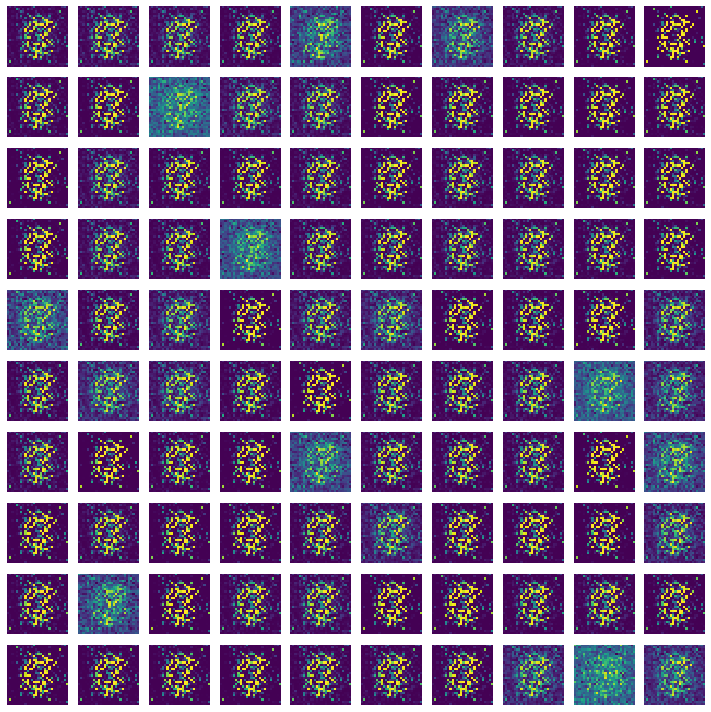

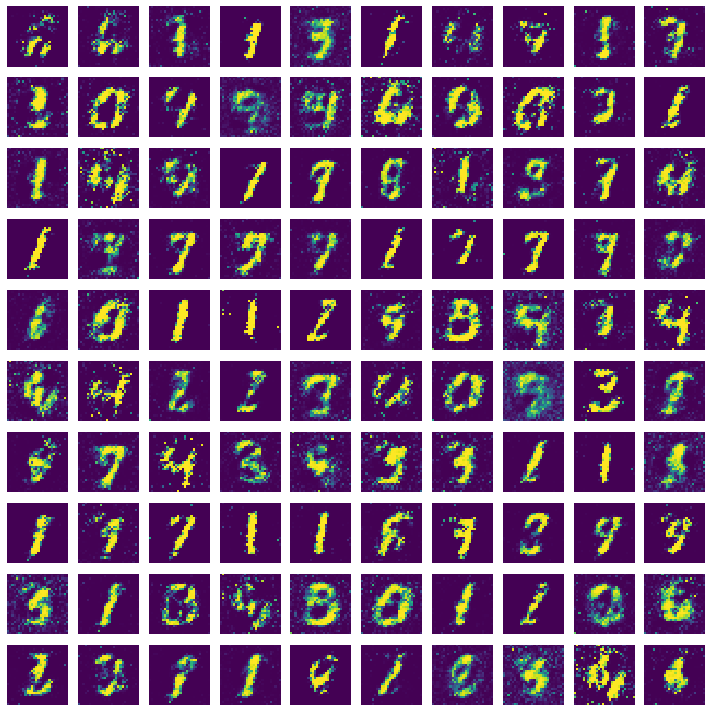

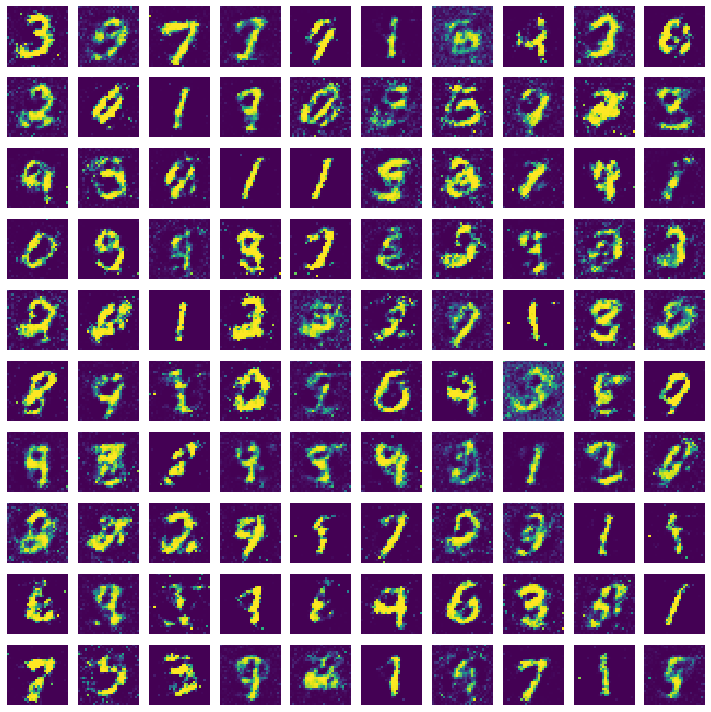

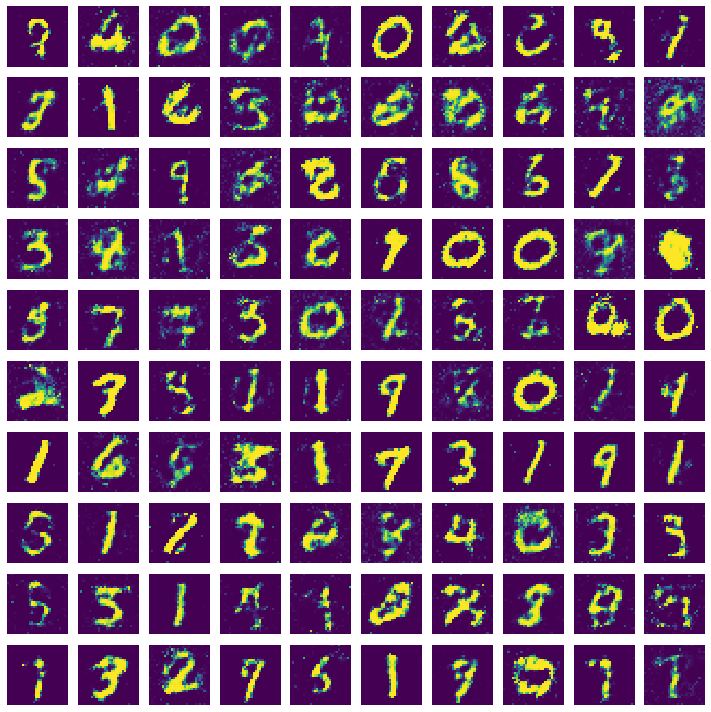

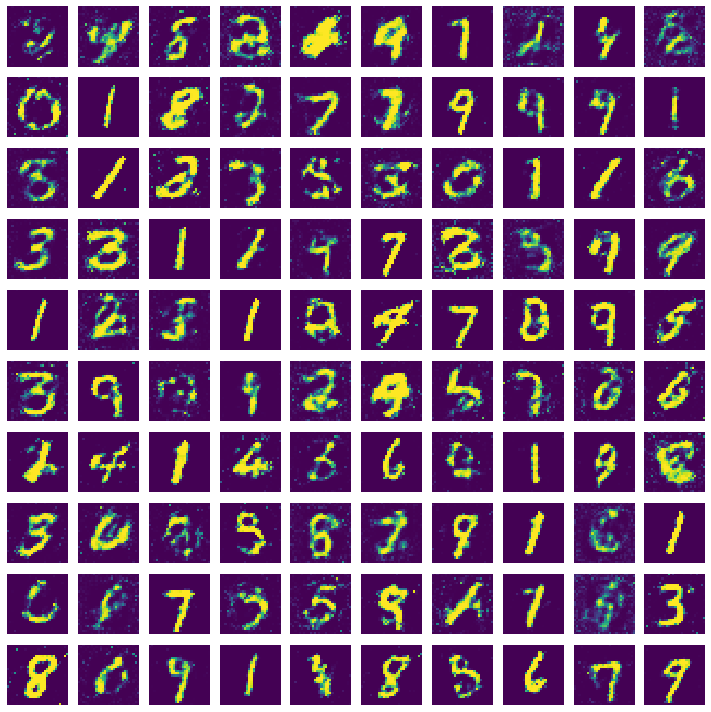

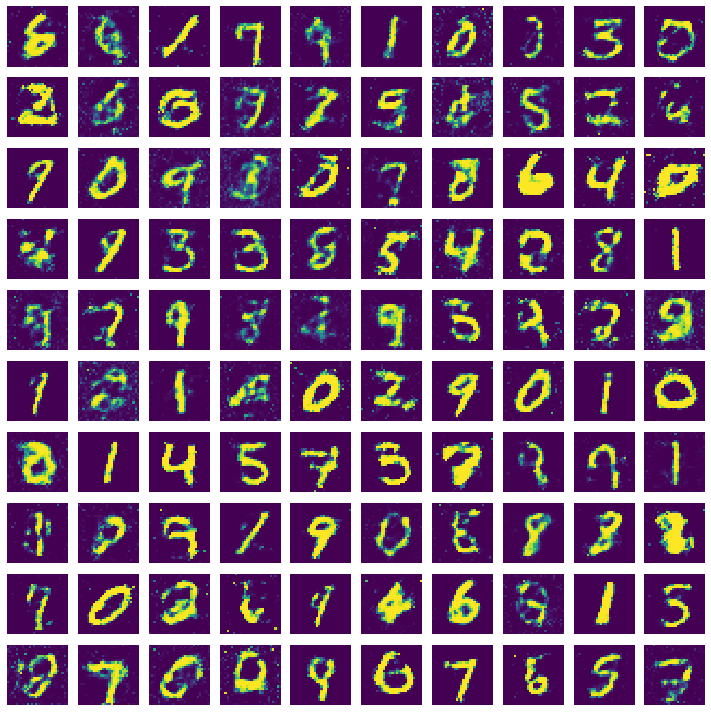

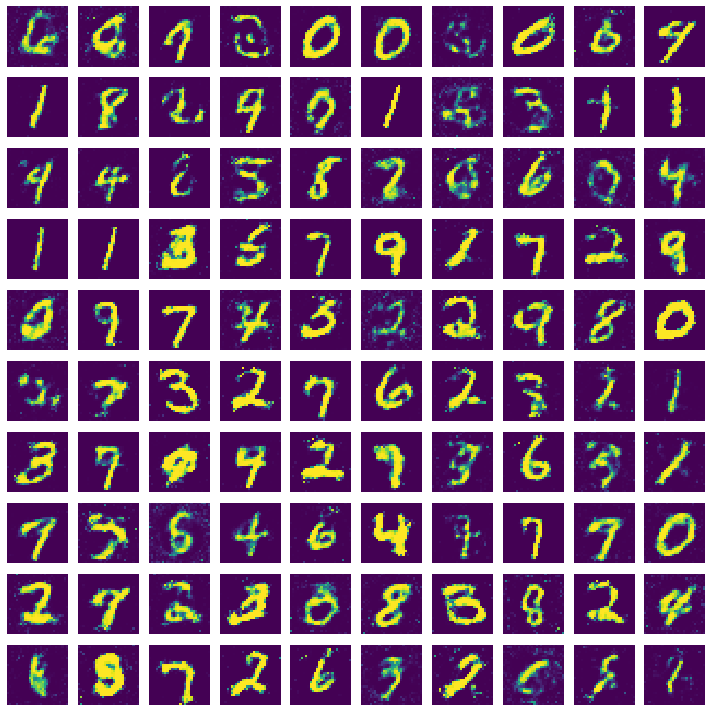

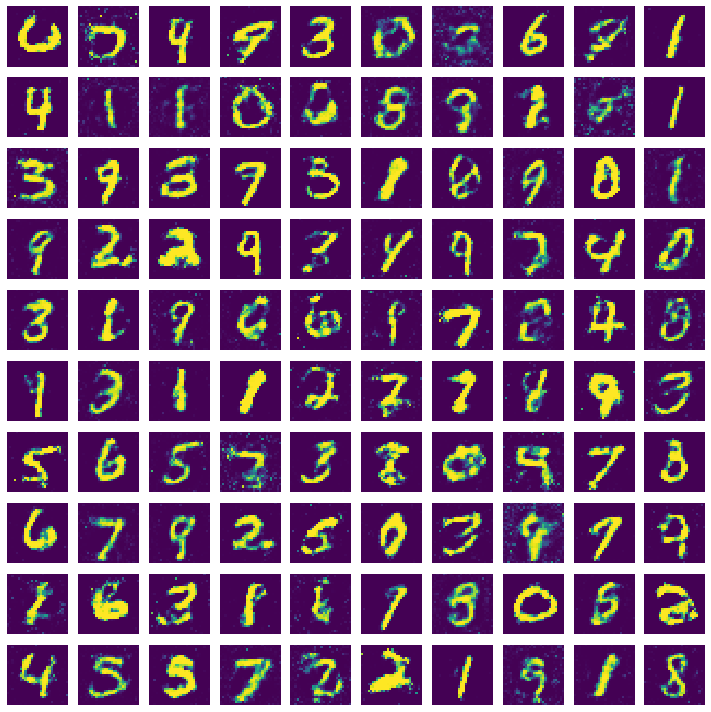

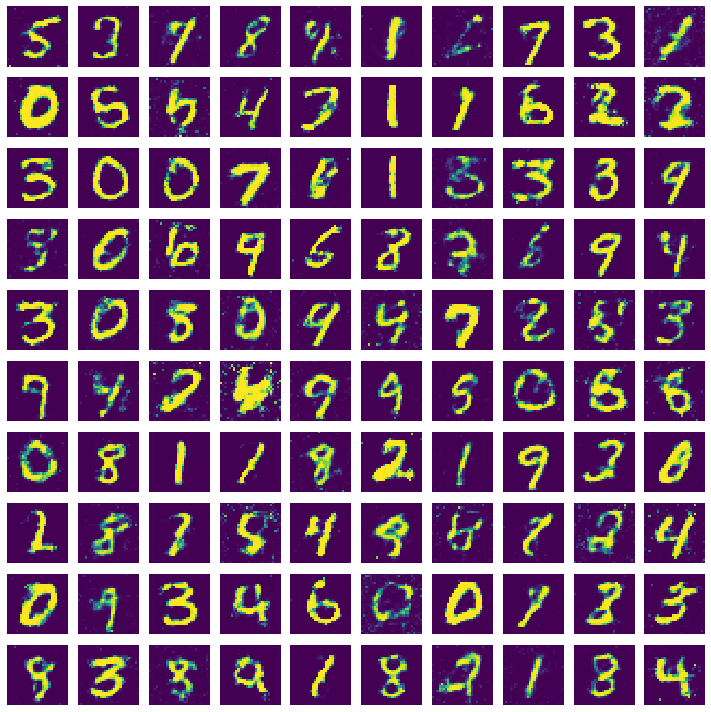

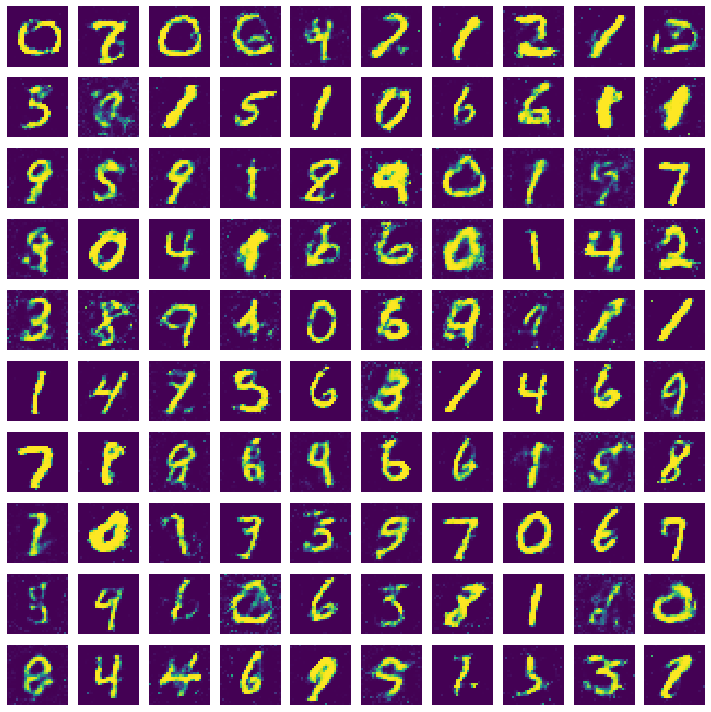

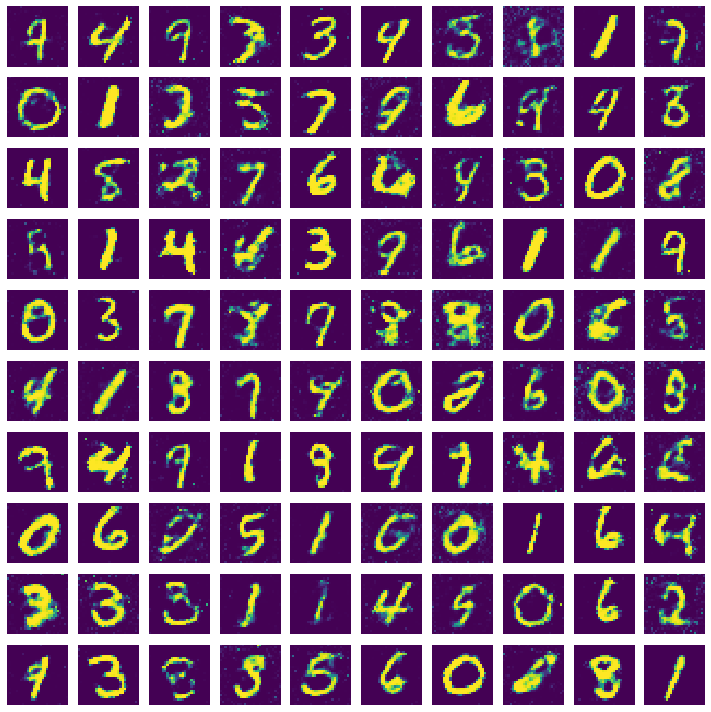

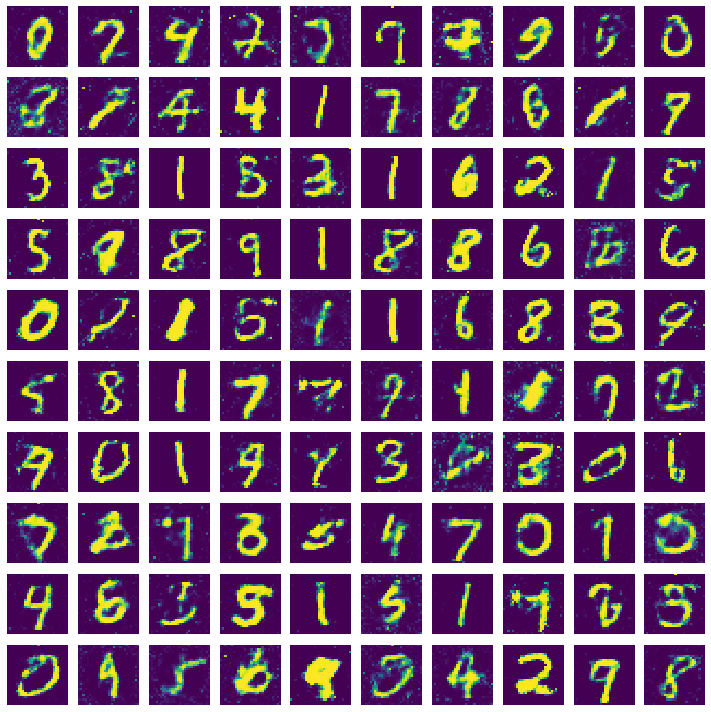

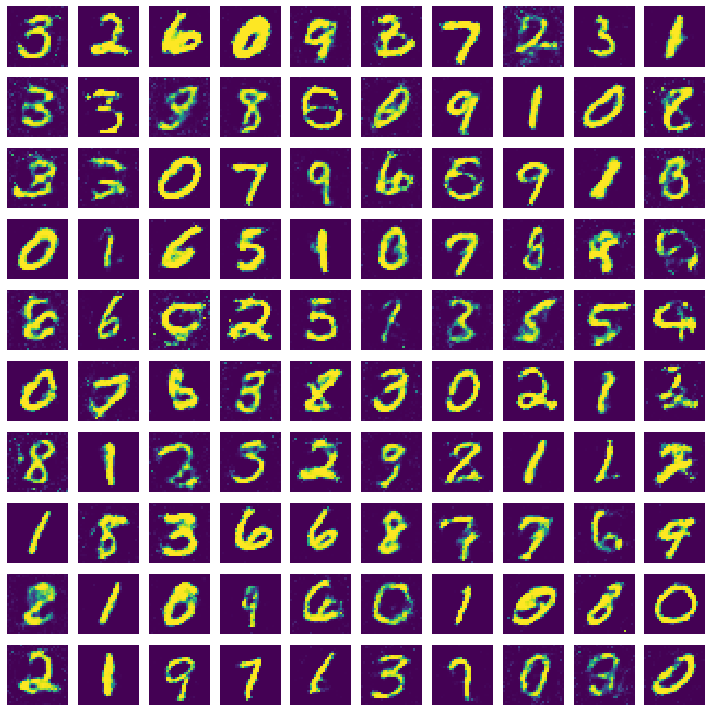

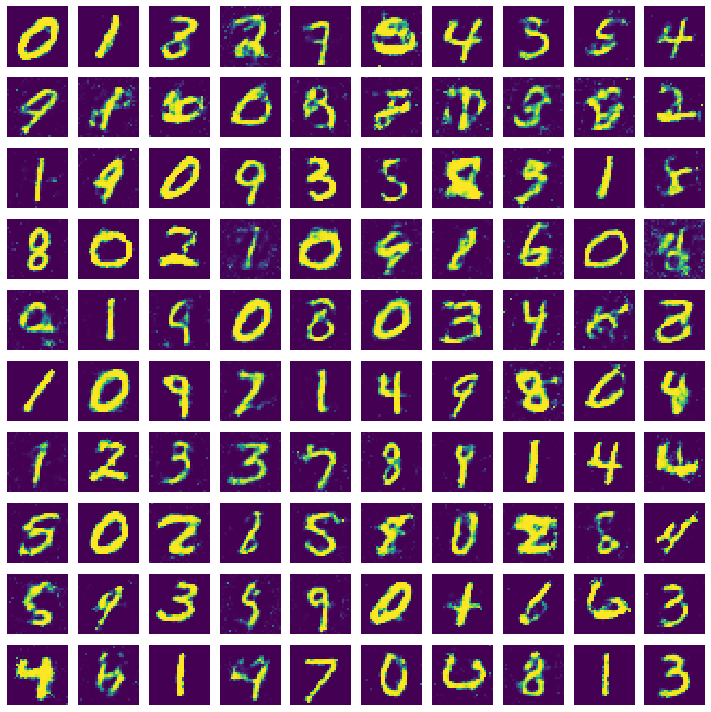

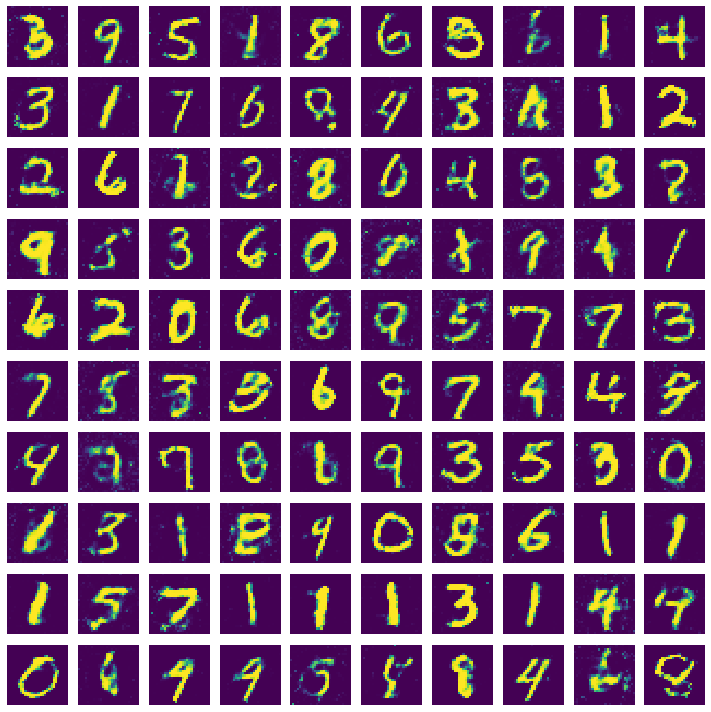

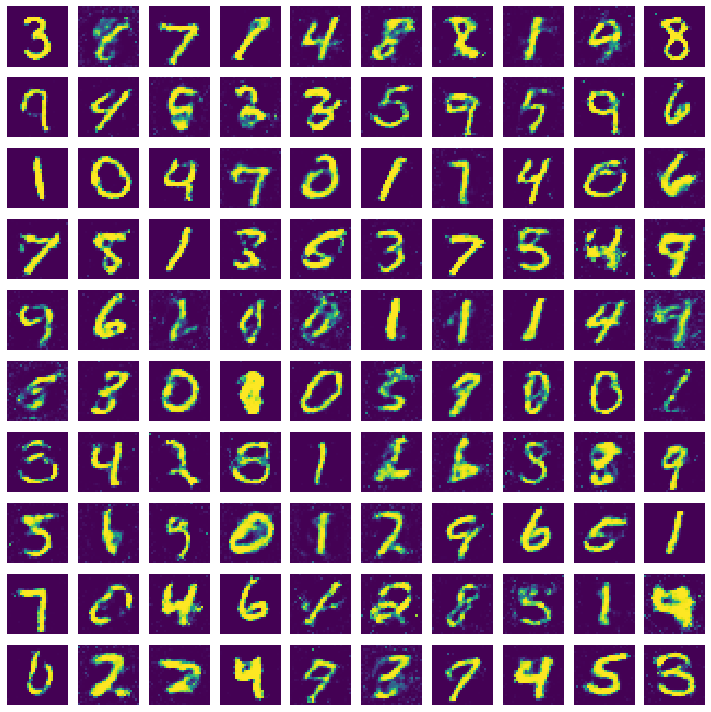

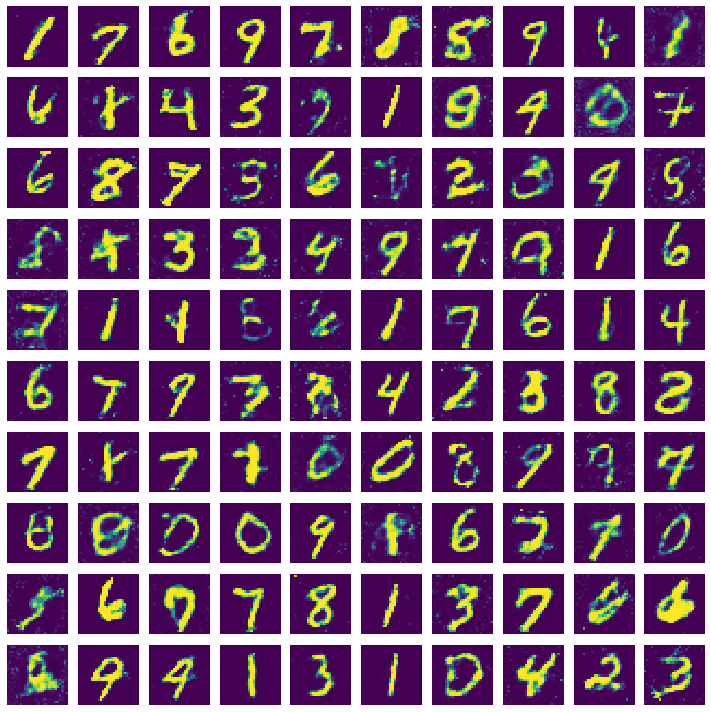

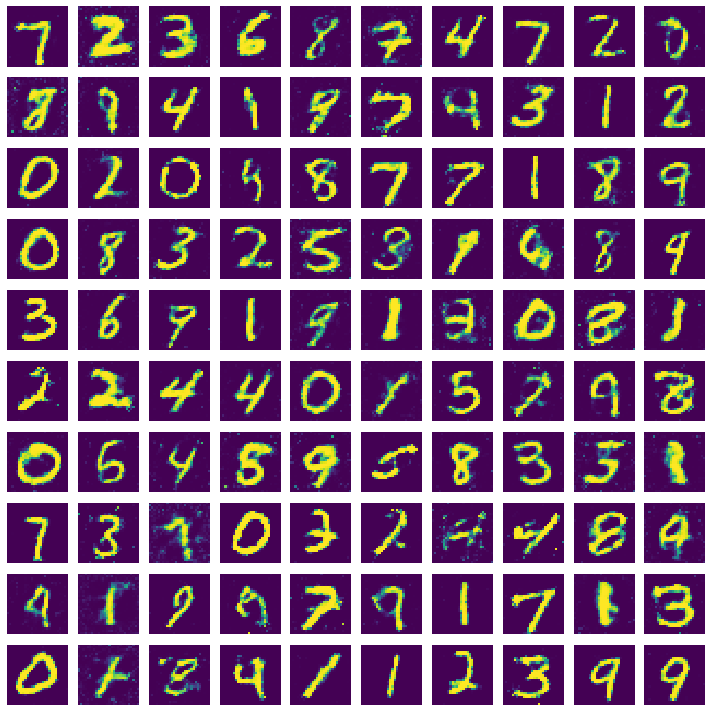

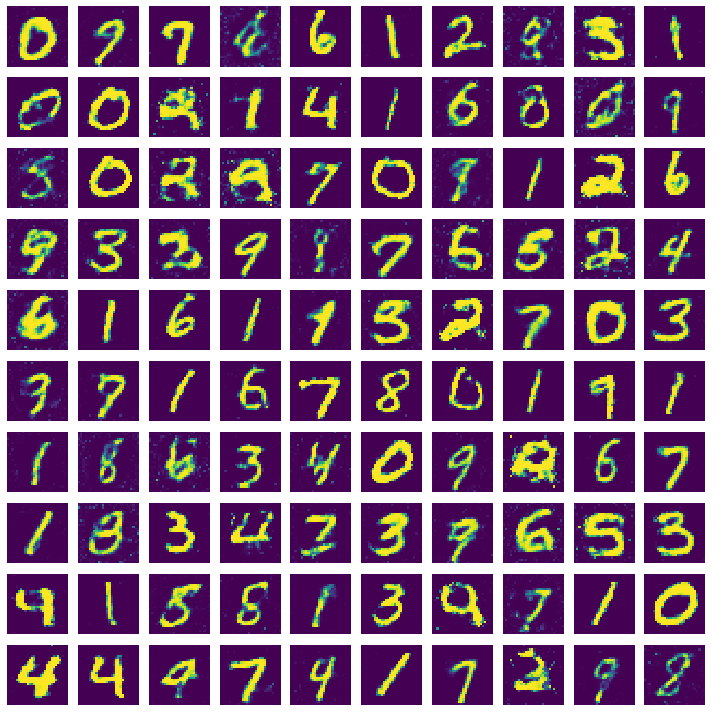

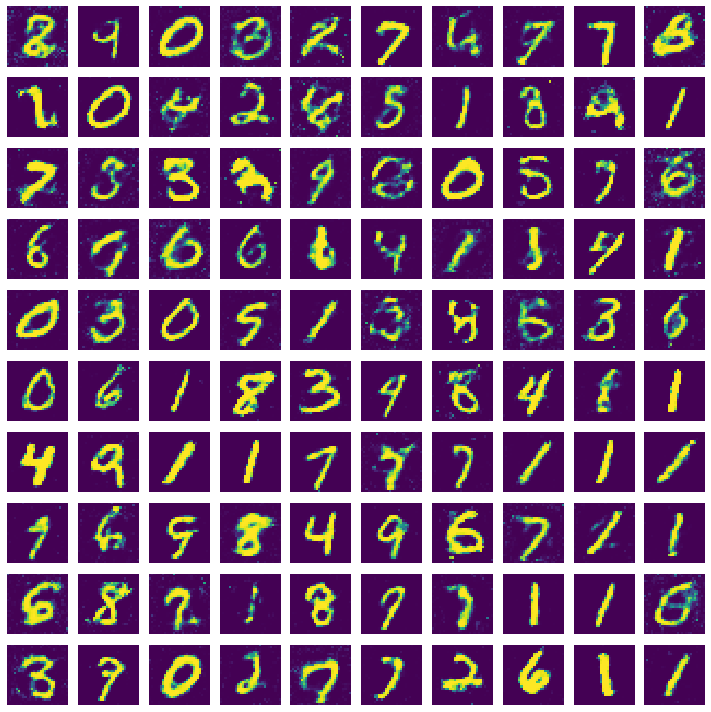

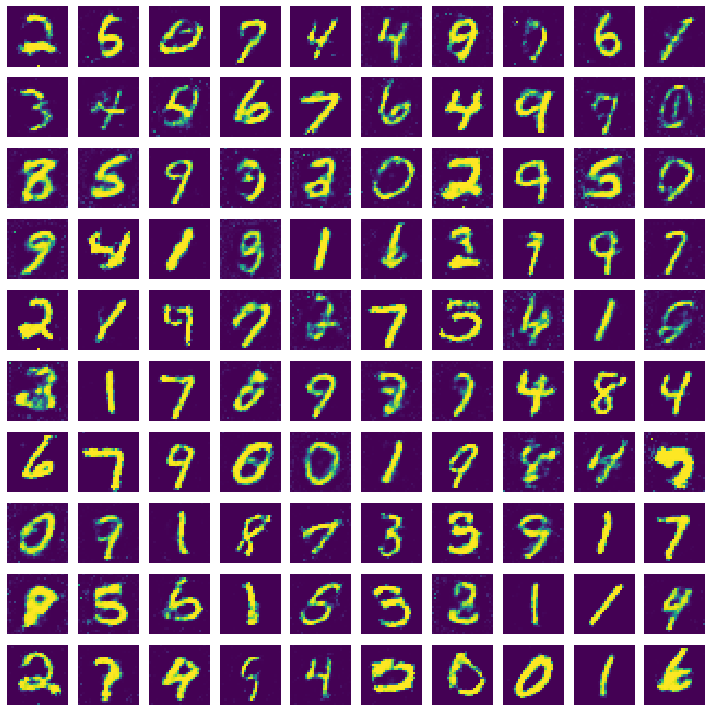

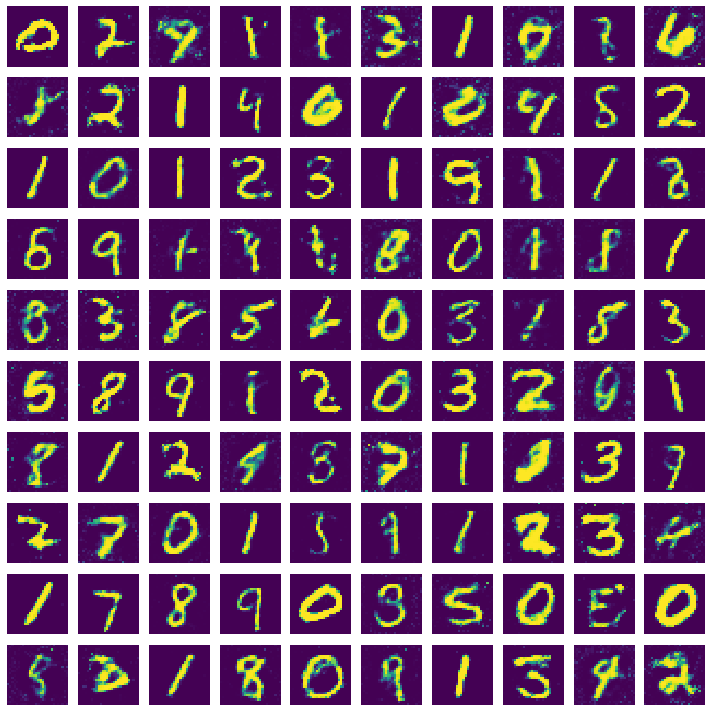

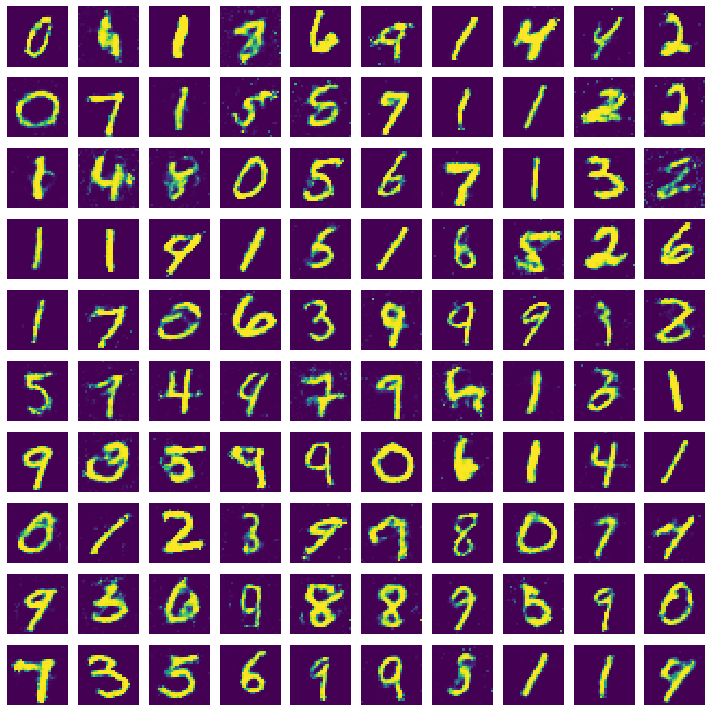

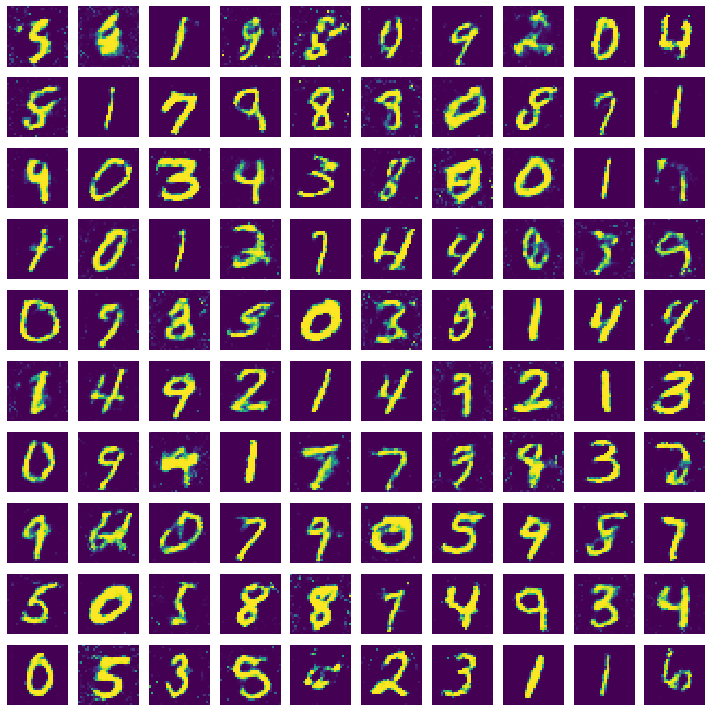

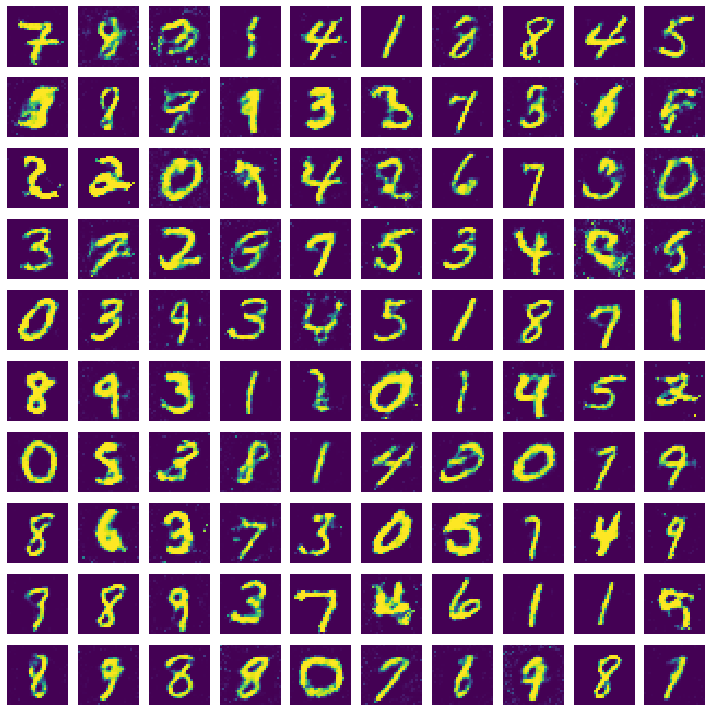

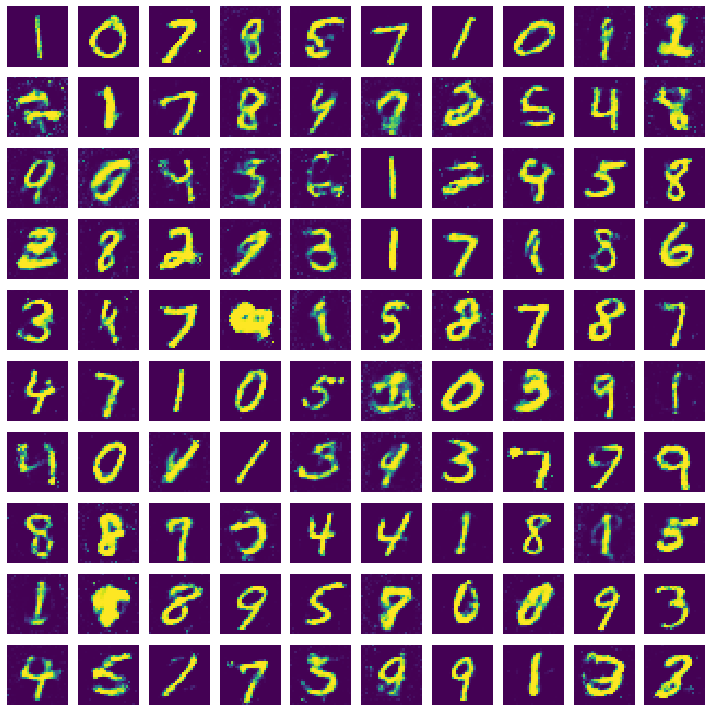

In [9]:
training(500,128)